# Sieci Konwolucyjne

## Wprowadzenie

<b>Splot</b> (<b>mnożenie splotowe, konwolucje</b>) definiujemy jako:

$$ (f_1 \ast f_2)(t) = \int_{-\infty}^{\infty} f_1(\tau)f_2(t - \tau)d\tau $$

i dla przypadków dyskretnych:


$$ (f_1 \ast f_2)[n] = \sum_{m = -\infty}^{\infty} f_1[n]f_2[n - m] $$



Splot jest działaniem:

- <b>przemiennym:</b> $$f_1 \ast f_2 = f_2 \ast f_1 $$

- <b>łącznym:</b> $$(f_1 \ast f_2)\ast f_3 = f_1 \ast (f_2 \ast f_3)$$

- <b>rozdzielnym względem dodawania:</b> $$ (f_1 + f_2) \ast f_3 = f_1 \ast f_3 + f_2 \ast f_3$$

Intuicyjnie możemy traktować splot jako ważenie jednej funkcji za pomocą drugiej. Dobrze pokazuje to przykład wyznaczania [splotu dyskretnego](https://www.eecs.tu-berlin.de/fileadmin/fg144/Courses/07WS/compPhoto/Convolution_charts.pdf).

[![splot macierzy](https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196&zoom=2)](https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196&zoom=2)


### Korelacja wzajemna (krzyżowa), autokorelacja

Szczególnym przypadkiem mnożenia splotowego jest <b>korelacja krzyżowa</b>, czyli miara podobieństwa dwóch szeregów czasowych przesuniętych od siebie o $\Delta t$:
$$ (f_1 \star f_2)(t) = \int_{-\infty}^{\infty} f_1(\tau)f_2(t + \tau)dt $$

i dla przypadków dyskretnych:


$$ (f_1 \star f_2)[n] = \sum_{m = -\infty}^{\infty} f_1[n]f_2[n + m] $$

jej szczególnym przypadkiem jest <b>autokorelacja</b>.

[![splot macierzy](https://upload.wikimedia.org/wikipedia/commons/2/21/Comparison_convolution_correlation.svg)](https://en.wikipedia.org/wiki/Cross-correlation)

### Zastosowania 

Do podstawowych zastosowań splotu możemy zaliczyć:

- Wyliczanie średniej ruchomej:

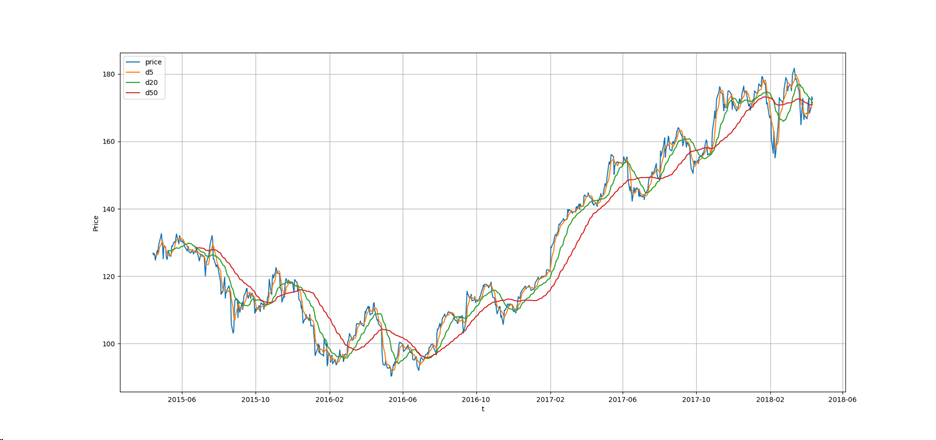

- Jądrowy estymator gęstości:

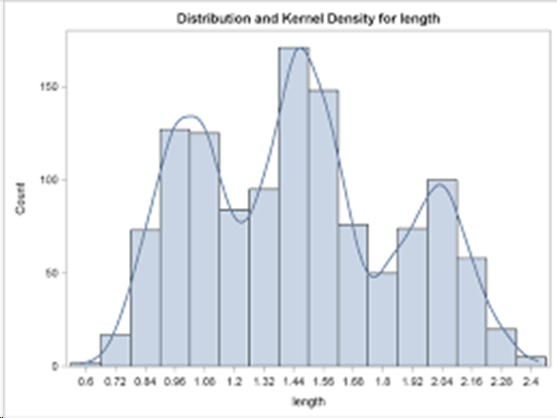

- Modulacja dźwięku (np. pogłos):

In [ ]:
using WAV, DSP

In [ ]:
isfile("audio_filtering_original.wav") ||
  download("https://stanford.edu/class/ee103/julia_files/audio_filtering_original.wav","audio_filtering_original.wav")

In [ ]:
x, f = wavread("audio_filtering_original.wav");
x = vec(x);

In [ ]:
wavplay(x, f);

In [ ]:
h_smooth = 1 / 44 * ones(44);
output = DSP.conv(h_smooth, x);


In [ ]:
wavwrite(x, f, "audio_filtering_original_smoothed.wav");
wavplay(output, f);

- Filtrowanie obrazów (np. wykrywanie krawędzi):

In [ ]:
using Images, TestImages

In [ ]:
img = testimage("mandrill")
img

In [ ]:
imfilter(img, Kernel.Laplacian())

## Sieci konwolucyjne (CNN)

[![](https://res.mdpi.com/entropy/entropy-19-00242/article_deploy/html/images/entropy-19-00242-g001.png)](https://towardsdatascience.com/how-to-teach-a-computer-to-see-with-convolutional-neural-networks-96c120827cd1)

Klasyczna architektura sieci konwolucyjnej sprowadza się do trzech specificznych, następujących po sobie warstw:

#### Warstwa konwolucyjna

Jest to podstawowa warstwa głębokiej sieci neuronowej. Jak wiemy konwolucje możemy nałożyć jako filtr na [różne typy danych](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29). Jest to też sposób w jaki przygotowuje się dane do pracy z klasycznymi modelami uczenia maszynowego. Jednak w takim wypadku musimy sami przyjąć jakie filtry będą nam potrzebne i kiedy.
Co jednak jeśli bylibyśmy w stanie zbudować model, który sam nauczy się które filtry są najodpowiedniejsze dla danego zagadnienia?

Na tym właśnie polega uczenie sieci konwolucyjnych. Zamiast klasycznych wag wykorzystuje się jądra konwolucji (zwane <b>mapami własności</b> - <i>feature maps</i>), które są optymalizowane w procesie uczenia.

#### Wprowadzenie nieliniowości (<i>detector stage</i>):

Konwolucja jest ze swojej definicji operacją liniową, w rzeczywistości relacje pomiędzy elementami otaczającej nas rzeczywistości są nieliniowe. Z sieci neuronowych korzystamy przede wszystkim w celu ich wychwytywania, przez co aby poprawić jakość aproksymacji konieczne jest przemonożenie wyników otrzymanych na warstwie konwolucyjnej przez nieliniową funkcję aktywacji (np. <b>ReLU</b>)

#### Pooling

Pooling możemy traktować jako "przycinanie" danych wychodzących z poprzedniej warstwy:

[![](http://ufldl.stanford.edu/wiki/images/0/08/Pooling_schematic.gif)](http://ufldl.stanford.edu/wiki/index.php/Pooling)

Wykorzystujemy go z kilku powodów:
- Przede wszystkim zmniejsza on rozmiar danych na każdej kolejnej warstwie, dzięki temu możemy zbudować głębsze modele, które będą się efektywniej uczyły.
- Dzięki temu, że kolejne obrazy są coraz gorszej jakości (mają mniejszy rozmiar) są one coraz bardziej odporne na przeuczenie.
- Pooling wiąże się też z założeniem o "stacjonarności" własności obrazu - zakładamy, że własność wykryta na jednym obszarze obrazu jest równie ważna na innych.
- Ponadto dzięki poolingowi aproksymacja <b>niezmienna względem nieznacznych przekształceń danych wejściowych i skali obrazu</b>.

Istnieje kilka podstawowych rodzajów poolingu:
- <b>max-pooling</b>
- <b>min-pooling</b>
- <b>mean-pooling</b>

## Przykład

Zacznijmy od wczytania bibliotek i [danych](https://github.com/zalandoresearch/fashion-mnist):

In [1]:
using Flux, Flux.Data.FashionMNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON, LinearAlgebra
train_labels = FashionMNIST.labels();
train_imgs = FashionMNIST.images();

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv C:\Users\p\.julia\packages\CUDAdrv\mCr0O\src\CUDAdrv.jl:69


Przyjmijmy podstawowe parametry uczenia:

In [2]:
epochs = 100;
batch_size = 64;

Zdefiniujmy funkcję, która podzieli nam zbiór na partycje o rozmiarze <tt>batch_size</tt>:

In [3]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end


make_minibatch (generic function with 1 method)

Podzielmy zbiór:

In [4]:
mb_idxs = partition(1:length(train_imgs), batch_size)
train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs];

In [5]:
loss(train_set[1][1],train_set[1][2])

UndefVarError: UndefVarError: loss not defined

Przygotujmy zbiór testowy:

In [6]:
# Prepare test set as one giant minibatch:
test_imgs = FashionMNIST.images(:test)
test_labels = FashionMNIST.labels(:test)
test_set = make_minibatch(test_imgs, test_labels, 1:length(test_imgs));

Zdefiniujmy model:

In [7]:
model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),
    softmax,
);

Sprekompilujmy model:

In [8]:
model(train_set[1][1])

10×64 Array{Float32,2}:
 0.112887   0.100288   0.102187   …  0.101524   0.104111   0.103513 
 0.0906642  0.093967   0.101268      0.0942511  0.0922079  0.0942906
 0.108343   0.0906798  0.0926827     0.0899073  0.0946499  0.0957433
 0.101388   0.105954   0.107065      0.104599   0.108159   0.104042 
 0.0992354  0.109567   0.101493      0.103996   0.104993   0.10356  
 0.106708   0.10562    0.105255   …  0.105538   0.109072   0.106667 
 0.10397    0.107943   0.104077      0.110672   0.0998573  0.0997293
 0.0972867  0.0918584  0.092808      0.0960118  0.0935647  0.0983559
 0.0871199  0.0991556  0.0953714     0.0961462  0.0963132  0.0971727
 0.0923979  0.0949673  0.0977934     0.0973551  0.097073   0.0969262

Zdefiniujmy funkcję straty:

In [9]:
function loss(x, y)
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x))
    y_hat = model(x_aug)
    return crossentropy(y_hat, y)
end


loss (generic function with 1 method)

In [10]:
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [11]:
@time accuracy(test_set[1],test_set[2])

 17.134511 seconds (4.13 M allocations: 1.915 GiB, 11.24% gc time)


0.1143

i optymalizator:

In [12]:
opt = ADAM(0.001)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

Zacznijmy trenować model:

In [15]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, params(model), train_set, opt)
    acc = accuracy(test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= 0.90
        @info(" -> Early-exiting: We reached our target accuracy of 90%")
        break
    end
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to fashionMNIST_conv.bson")
        BSON.@save "fashionMNIST_conv.bson" model epoch acc
        best_acc = acc
        last_improvement = epoch
    end
    if epoch - last_improvement >= 5 && opt.eta > 1e-6
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")
        last_improvement = epoch
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[15]:1
┌ Info: [1]: Test accuracy: 0.8403
└ @ Main In[15]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[15]:14
┌ Info: [2]: Test accuracy: 0.8592
└ @ Main In[15]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[15]:14
┌ Info: [3]: Test accuracy: 0.8751
└ @ Main In[15]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[15]:14
┌ Info: [4]: Test accuracy: 0.8805
└ @ Main In[15]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[15]:14
┌ Info: [5]: Test accuracy: 0.8824
└ @ Main In[15]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[15]:14
┌ Info: [6]: Test accuracy: 0.8862
└ @ Main In[15]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[15]:14
┌ Info: [7]: Test accuracy: 0.8896
└ @ Main In[15]:8
┌ Info:  -> New be

Wczytajmy wynik:

In [ ]:
  isfile("fashionMNIST_conv.bson") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_conv.bson?raw=true")

In [16]:
BSON.@load "fashionMNIST_conv.bson" model

In [17]:
accuracy(test_set[1],test_set[2])

0.8957

In [18]:
con = Chain(model.layers[1:1]...)

Chain(Conv((3, 3), 1=>16, relu))

In [186]:
using Images

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1273


┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1273


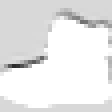

In [187]:
Gray.(1 .- con(train_set[1][1])[:,:,1,1])

I dla porównania:

In [172]:
mlp =   Chain(x -> reshape(x, :, size(x, 4)),
        Dense(784,256, relu),
        Dropout(0.4),
        Dense(256,128, relu),
        Dropout(0.4),
        Dense(128,10, relu),
        softmax,
);

In [179]:
α = 2.0f-6
function mlp_loss(x, y)
    y_hat = mlp(x)
    return crossentropy(y_hat, y) 
end
mlp_accuracy(x, y) = mean(onecold(mlp(x)) .== onecold(y))

mlp_accuracy (generic function with 1 method)

In [180]:
mlp_accuracy(test_set[1],test_set[2])

0.1006

In [181]:
opt = ADAM(0.0001)

ADAM(0.0001, (0.9, 0.999), IdDict{Any,Any}())

In [182]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(mlp_loss, params(mlp), train_set, opt)
    acc = mlp_accuracy(test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= 0.90
        @info(" -> Early-exiting: We reached our target accuracy of 90%")
        break
    end
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to fashionMNIST_mlp.bson")
        BSON.@save "fashionMNIST_mlp.bson" mlp epoch acc
        best_acc = acc
        last_improvement = epoch
    end
    if epoch - last_improvement >= 5 && opt.eta > 1e-20
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")
        last_improvement = epoch
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[182]:1
┌ Info: [1]: Test accuracy: 0.7942
└ @ Main In[182]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
└ @ Main In[182]:14
┌ Info: [2]: Test accuracy: 0.8225
└ @ Main In[182]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
└ @ Main In[182]:14
┌ Info: [3]: Test accuracy: 0.8366
└ @ Main In[182]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
└ @ Main In[182]:14
┌ Info: [4]: Test accuracy: 0.8446
└ @ Main In[182]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
└ @ Main In[182]:14
┌ Info: [5]: Test accuracy: 0.8525
└ @ Main In[182]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
└ @ Main In[182]:14
┌ Info: [6]: Test accuracy: 0.8550
└ @ Main In[182]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_mlp.bson
└ @ Main In[182]:14
┌ Info: [7]: Test accuracy: 0.8578
└ @ Main In[182]:8
┌ Info:  -

┌ Info: [84]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [85]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [86]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [87]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [88]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Warning:  -> Haven't improved in a while, dropping learning rate to 1.0000000000000002e-13!
└ @ Main In[182]:21
┌ Info: [89]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [90]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [91]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [92]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [93]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Warning:  -> Haven't improved in a while, dropping learning rate to 1.0000000000000002e-14!
└ @ Main In[182]:21
┌ Info: [94]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [95]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [96]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ Info: [97]: Test accuracy: 0.1000
└ @ Main In[182]:8
┌ 

In [ ]:
  isfile("fashionMNIST_mlp.bson") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_mlp.bson?raw=true")

In [184]:
BSON.@load "fashionMNIST_mlp.bson" mlp

In [185]:
mlp_accuracy(test_set[1],test_set[2])

0.8922

## Dlaczego sieci konwolucyjne są efektywne?

[Goodfellow, Bengio & Courville, Deep Learning (2016), rozdział 9](http://www.deeplearningbook.org/contents/convnets.html)

Sieci konwolucyjne posiadają kilka właściwości, które umożliwiają efektywniejsze uczenie:

### Rzadkie interakcje (<i>sparse interactions</i>, <i>sparse connectivity</i>)

Filtry, które wykorzystujemy do uczenia sieci konwolucyjnych są zazwyczaj wyraźnie mniejsze niż wektory danych wejściowych, dzięki czemu do ich przechowywania wykorzystujemy mniej pamięci a ich szacowanie wymaga mniejszej ilości operacji.

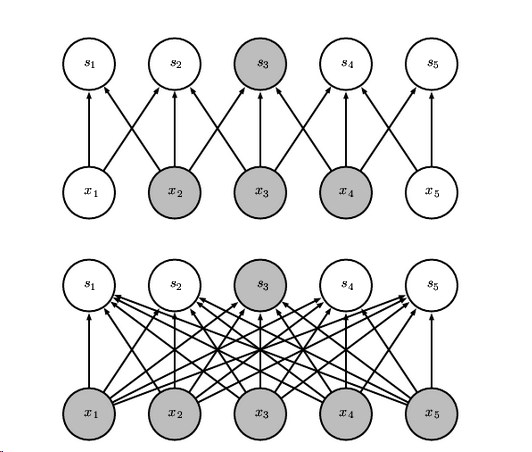

### Współdzielenie parametrów (<i>parameter sharing</i>):

Właściwość związana z rzadkimi interakcjami. W porównaniu z wielowartstwowymi perceptronami wagi, które wykorzystujemy do uczenia sieci konwolucyjnych wykorzystujemy do aproksymacji wielu zmiennych wejściowych jednocześnie (mówimy, że są one <b>związane</b>). Dzięki temu możemy przechowywać znacznie mniej informacji niż w wypadku innych modeli.

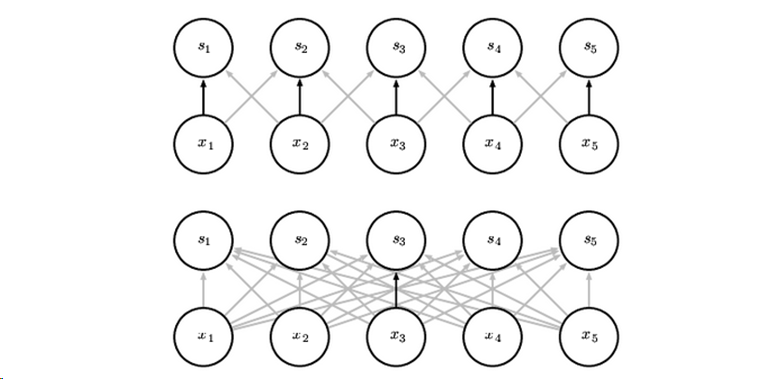

### Niezmienność względem przesunięcia  (<i>equivariant to  translation</i>).

Definiujemy ją jako:

$$ f(g(I))=g(f(I)) $$

Oznacza ona to, że równoległe przesunięcie funkcji (mapy własności) nie modyfikuje jej rezultatów. Dzięki temu możemy wykorzystać ten sam filtr do wykrywania charakterystyk w różnych fragmentach obrazu. 

### Niezmienność względem nieznacznych przekształceń  danych wejściowych i skali obrazu (<i>invariant to local translation</i>).


Niezmienność możemy zdefiniować jako: 

$$ f(g(I))=f(I) $$

Właściwość ta wynika bezpośrednio z faktu korzystania z poolingu podczas budowy sieci konwolucyjnych - poprzez uoqólnianie obrazu do coraz mniejszej macierzy jesteśmy w stanie wykorzystać mapy własności do rozpoznawania obiektów, które są obrócone, oświetlone w inny sposób, etc.

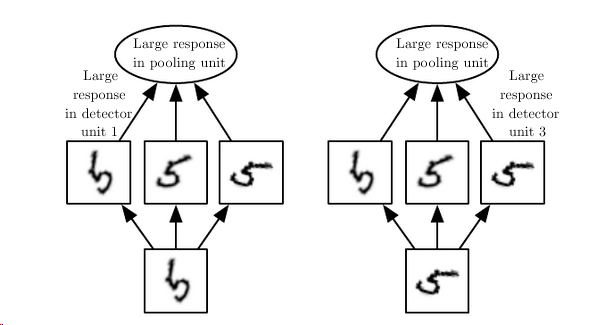

## Dodatkowa praca domowa

1. Wykaż, że splot jest:
    - przemienny
    - łączny
    - rozdzielny względem dodawania

2. Sprawdź czy można jeszcze poprawić efektywność predykcji prezentowanej na zajęciach sieci, jeżeli tak to zaprezentuj taki model, prześlij kod i model zapisany w formacie <tt>BSON</tt>, [wskazówka](https://github.com/zalandoresearch/fashion-mnist).

<b>Uwaga:</b> Poprawiony model musi mieć trafność predykcji na zbiorze testowym większą niż 91%, w przypadku gdy trafność będzie większa niż 95% oddanie pracy domowej oznacza zaliczenie przedmiotu z oceną 5.


## Cifar-10

[Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) to jeden z klasycznych zbiorów do benchmarku sieci neuronowych. Składa się z 60 000 kolorowych obrazów o wymiarach $ 32 \times 32$ podzielonych na 10 kategorii. Uchodzi za jeden z najtrudniejszych zbiorów do klasyfikacji. W jego przypadku konieczne jest wykorzystanie [bardziej złożonych architektur](https://arxiv.org/pdf/1409.1556.pdf).

In [ ]:
using Flux, Metalhead, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Metalhead: trainimgs
using Images: channelview
using Statistics: mean
using Base.Iterators: partition

# VGG16 and VGG19 models

vgg16() = Chain(
  Conv((3, 3), 3 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  Conv((3, 3), 64 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  Conv((3, 3), 128 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  x -> maxpool(x, (2,2)),
  Conv((3, 3), 128 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 256 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  x -> maxpool(x, (2, 2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(512, 4096, relu),
  Dropout(0.5),
  Dense(4096, 4096, relu),
  Dropout(0.5),
  Dense(4096, 10),
  softmax) |> gpu

vgg19() = Chain(
  Conv((3, 3), 3 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  Conv((3, 3), 64 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  Conv((3, 3), 128 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 128 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 256 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  x -> maxpool(x, (2, 2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(512, 4096, relu),
  Dropout(0.5),
  Dense(4096, 4096, relu),
  Dropout(0.5),
  Dense(4096, 10),
  softmax) |> gpu

# Function to convert the RGB image to Float64 Arrays

getarray(X) = Float32.(permutedims(channelview(X), (2, 3, 1)))

# Fetching the train and validation data and getting them into proper shape

X = trainimgs(CIFAR10)
imgs = [getarray(X[i].img) for i in 1:50000]
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)
train = gpu.([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 100)])
valset = collect(49001:50000)
valX = cat(imgs[valset]..., dims = 4) |> gpu
valY = labels[:, valset] |> gpu

# Defining the loss and accuracy functions

m = vgg16()

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

# Defining the callback and the optimizer

evalcb = throttle(() -> @show(accuracy(valX, valY)), 10)

opt = ADAM()

# Starting to train models

Flux.train!(loss, params(m), train, opt, cb = evalcb)

# Fetch the test data from Metalhead and get it into proper shape.
# CIFAR-10 does not specify a validation set so valimgs fetch the testdata instead of testimgs

test = valimgs(CIFAR10)

testimgs = [getarray(test[i].img) for i in 1:10000]
testY = onehotbatch([test[i].ground_truth.class for i in 1:10000], 1:10) |> gpu
testX = cat(testimgs..., dims = 4) |> gpu

# Print the final accuracy

@show(accuracy(testX, testY))